# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [6]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [7]:
torch.cuda.empty_cache()
import gc
gc.collect()
import psutil

# Получение информации о памяти
print(f"Available memory: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")
print(f"Used memory: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")

Available memory: 10.50 GB
Used memory: 1.87 GB


In [8]:
import PIL
print(PIL.__version__)

9.4.0


In [9]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [10]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [11]:
!ls train

simpsons_dataset


In [12]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Aug  7 08:04:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [13]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [14]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [15]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [16]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [17]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [18]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [19]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [20]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [21]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

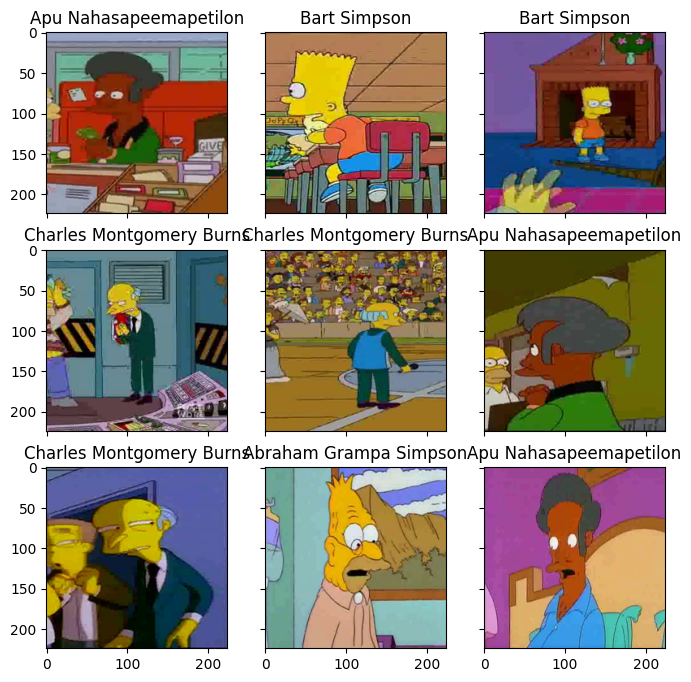

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [76]:
# # Очень простая сеть
# class SimpleCnn(nn.Module):

#     def __init__(self, n_classes):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.out = nn.Linear(96 * 5 * 5, n_classes)


#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)

#         x = x.view(x.size(0), -1)
#         logits = self.out(x)
#         return logits


class SimpleCnn(nn.Module):
    def __init__(self, num_classes=42):
        super(SimpleCnn, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 3 * 3, 512),  # Учитываем выходной размер после слоев MaxPool
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [78]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [79]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    with torch.no_grad():  # Отключаем вычисление градиентов
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()
            processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [80]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    model = model.to()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [81]:
def predict(model, test_loader, device):
    logits = []
    with torch.no_grad():
        model.eval()
        for inputs in test_loader:
            # Move inputs to the same device as the model
            inputs = inputs.to(device)
            outputs = model(inputs)
            logits.append(outputs.cpu())
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [82]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, d

Запустим обучение сети.

In [83]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [84]:
import psutil

# Получение информации о памяти
print(f"Available memory: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")
print(f"Used memory: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")


Available memory: 9.60 GB
Used memory: 2.75 GB


In [85]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=30, batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
epoch:   3%|▎         | 1/30 [02:00<58:19, 120.66s/it]


Epoch 001 train_loss: 2.2413     val_loss 1.2730 train_acc 0.3972 val_acc 0.6733


epoch:   7%|▋         | 2/30 [04:04<57:11, 122.54s/it]


Epoch 002 train_loss: 0.9831     val_loss 0.7868 train_acc 0.7368 val_acc 0.7872


epoch:  10%|█         | 3/30 [06:09<55:44, 123.86s/it]


Epoch 003 train_loss: 0.5945     val_loss 0.6392 train_acc 0.8345 val_acc 0.8267


epoch:  13%|█▎        | 4/30 [08:15<54:01, 124.67s/it]


Epoch 004 train_loss: 0.3837     val_loss 0.5783 train_acc 0.8946 val_acc 0.8397


epoch:  17%|█▋        | 5/30 [10:19<51:46, 124.27s/it]


Epoch 005 train_loss: 0.2706     val_loss 0.5689 train_acc 0.9259 val_acc 0.8580


epoch:  20%|██        | 6/30 [12:23<49:38, 124.09s/it]


Epoch 006 train_loss: 0.2177     val_loss 0.4980 train_acc 0.9372 val_acc 0.8791


epoch:  23%|██▎       | 7/30 [14:23<47:05, 122.83s/it]


Epoch 007 train_loss: 0.1518     val_loss 0.5096 train_acc 0.9582 val_acc 0.8961


epoch:  27%|██▋       | 8/30 [16:28<45:14, 123.39s/it]


Epoch 008 train_loss: 0.1628     val_loss 0.5416 train_acc 0.9557 val_acc 0.8817


epoch:  30%|███       | 9/30 [18:31<43:13, 123.49s/it]


Epoch 009 train_loss: 0.1568     val_loss 0.6073 train_acc 0.9573 val_acc 0.8695


epoch:  33%|███▎      | 10/30 [20:38<41:28, 124.42s/it]


Epoch 010 train_loss: 0.0934     val_loss 0.7200 train_acc 0.9741 val_acc 0.8672


epoch:  37%|███▋      | 11/30 [22:43<39:26, 124.54s/it]


Epoch 011 train_loss: 0.0921     val_loss 0.7048 train_acc 0.9736 val_acc 0.8821


epoch:  40%|████      | 12/30 [24:47<37:22, 124.57s/it]


Epoch 012 train_loss: 0.1162     val_loss 0.6183 train_acc 0.9703 val_acc 0.8789


epoch:  43%|████▎     | 13/30 [26:51<35:11, 124.23s/it]


Epoch 013 train_loss: 0.1814     val_loss 0.7023 train_acc 0.9564 val_acc 0.8561


epoch:  47%|████▋     | 14/30 [28:53<32:58, 123.64s/it]


Epoch 014 train_loss: 0.1169     val_loss 0.6880 train_acc 0.9694 val_acc 0.8815


epoch:  50%|█████     | 15/30 [30:55<30:49, 123.27s/it]


Epoch 015 train_loss: 0.0737     val_loss 0.6697 train_acc 0.9810 val_acc 0.8863


epoch:  53%|█████▎    | 16/30 [32:56<28:35, 122.55s/it]


Epoch 016 train_loss: 0.0725     val_loss 0.7573 train_acc 0.9796 val_acc 0.8890


epoch:  57%|█████▋    | 17/30 [35:00<26:39, 123.00s/it]


Epoch 017 train_loss: 0.0886     val_loss 0.7057 train_acc 0.9778 val_acc 0.8827


epoch:  60%|██████    | 18/30 [37:03<24:34, 122.86s/it]


Epoch 018 train_loss: 0.0665     val_loss 0.7662 train_acc 0.9826 val_acc 0.8882


epoch:  63%|██████▎   | 19/30 [39:08<22:40, 123.64s/it]


Epoch 019 train_loss: 0.0514     val_loss 0.7095 train_acc 0.9873 val_acc 0.8863


epoch:  67%|██████▋   | 20/30 [41:25<21:15, 127.54s/it]


Epoch 020 train_loss: 0.0384     val_loss 0.8207 train_acc 0.9899 val_acc 0.8626


epoch:  70%|███████   | 21/30 [43:30<19:00, 126.72s/it]


Epoch 021 train_loss: 0.0923     val_loss 0.7917 train_acc 0.9771 val_acc 0.8821


epoch:  73%|███████▎  | 22/30 [45:33<16:45, 125.69s/it]


Epoch 022 train_loss: 0.1121     val_loss 0.8406 train_acc 0.9732 val_acc 0.8699


epoch:  77%|███████▋  | 23/30 [47:37<14:36, 125.26s/it]


Epoch 023 train_loss: 0.0806     val_loss 0.7274 train_acc 0.9812 val_acc 0.8823


epoch:  80%|████████  | 24/30 [49:41<12:29, 124.90s/it]


Epoch 024 train_loss: 0.0488     val_loss 1.0465 train_acc 0.9875 val_acc 0.8747


epoch:  83%|████████▎ | 25/30 [51:49<10:28, 125.70s/it]


Epoch 025 train_loss: 0.0965     val_loss 0.7809 train_acc 0.9787 val_acc 0.8770


epoch:  87%|████████▋ | 26/30 [53:57<08:25, 126.41s/it]


Epoch 026 train_loss: 0.0425     val_loss 0.7845 train_acc 0.9900 val_acc 0.8857


epoch:  90%|█████████ | 27/30 [55:59<06:15, 125.14s/it]


Epoch 027 train_loss: 0.0415     val_loss 0.9904 train_acc 0.9904 val_acc 0.8672


epoch:  93%|█████████▎| 28/30 [58:06<04:11, 125.63s/it]


Epoch 028 train_loss: 0.1136     val_loss 0.8376 train_acc 0.9771 val_acc 0.8829


epoch:  97%|█████████▋| 29/30 [1:00:13<02:06, 126.19s/it]


Epoch 029 train_loss: 0.0656     val_loss 0.8828 train_acc 0.9876 val_acc 0.8814


epoch: 100%|██████████| 30/30 [1:02:17<00:00, 124.59s/it]


Epoch 030 train_loss: 0.0382     val_loss 0.7881 train_acc 0.9911 val_acc 0.8905


Построим кривые обучения

In [86]:
loss, acc, val_loss, val_acc = zip(*history)

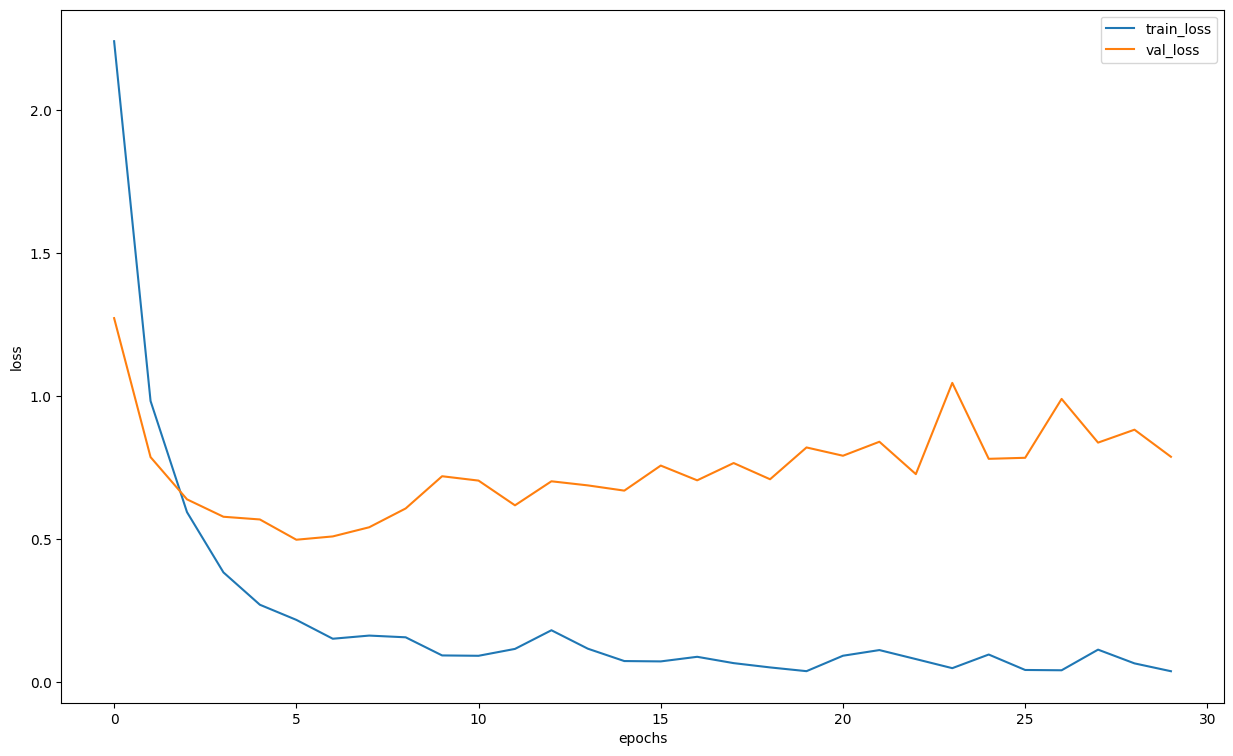

In [87]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [88]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [89]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [90]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs, 'cuda')

In [91]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [92]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [93]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.9500000000000001


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

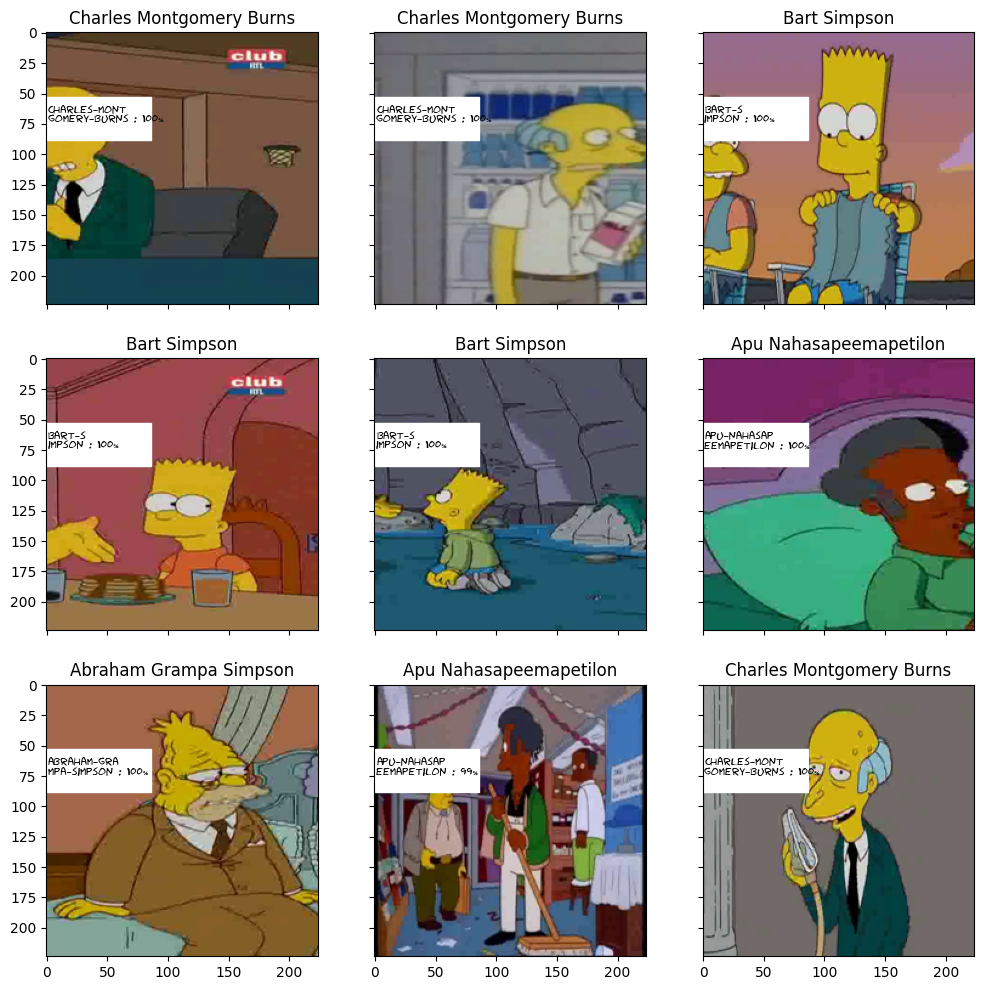

In [94]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [95]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader, 'cuda')


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [96]:
! ls

characters_illustration.png  sample_data			 simple_cnn_baseline_v2.csv
gdrive			     sample_submission.csv		 testset
label_encoder.pkl	     simple_cnn_baseline_v2_correct.csv  train


In [97]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [63]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [98]:
my_submit.to_csv('simple_cnn_baseline_v3.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
